# An√°lise de Subtipos Moleculares

Este notebook integra todas as etapas do fluxo de trabalho para an√°lise de subtipos moleculares, utilizando os m√≥dulos modularizados.

### **Configura√ß√£o Inicial e Importa√ß√µes**

In [1]:
# Importa√ß√µes padr√£o
import pandas as pd
import importlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import shap

# Importar m√≥dulos personalizados
from modules.data_loader import DataLoader
from modules.preprocessor import Preprocessor
from modules.modeling import RandomForestKFoldRunner
from modules.visualization import Visualization

from modules.panel_manager import PanelManager
import modules.model_evaluation as model_evaluation_module
import modules.visualization as visualization_module
from modules.model_evaluation import ModelEvaluator

In [2]:
# Configurar diret√≥rios
data_dir = 'datas'
output_dir = 'outputs'
results_dir = 'results'

# Criar diret√≥rios se n√£o existirem
for directory in [output_dir, results_dir]:
    if not os.path.exists(directory):
        os.makedirs(directory)

# **Etapa 1. Gera√ß√£o da Tabela de Genes Vs Subtipos**

### 1.1. Carregamento de Dados

In [3]:
# Inicializar o carregador de dados
data_loader = DataLoader(data_dir=data_dir)

# Carregar dados cl√≠nicos
clinical_data = data_loader.load_clinical_data()
clinical_data.head()

Sample ID   Subtype
0  TCGA-BR-8077-01  STAD_CIN
1  TCGA-BR-8289-01  STAD_CIN
2  TCGA-BR-8291-01  STAD_CIN
3  TCGA-F1-6875-01  STAD_CIN
4  TCGA-D7-8574-01   STAD_GS

### Informa√ß√µes sobre o conjunto de dados

**Subtipos Moleculares**

In [4]:
# Estat√≠sticas dos subtipos
subtype_stats = data_loader.get_subtype_statistics(clinical_data)

Quantidade total de casos: 383

Quantidade de casos por subtipo:
Subtype
STAD_CIN     223
STAD_MSI      73
STAD_GS       50
STAD_EBV      30
STAD_POLE      7
Name: count, dtype: int64
Porcentagem por classe:
CIN: 58.22%
MSI: 19.06%
GS: 13.05%
EBV: 7.83%
POLE: 1.83%


**SNV**

In [5]:
# Carregar dados som√°ticos
somatic_data = data_loader.load_somatic_data()
somatic_data.head()

gene         Sample_ID              effect
0  CLSTN1  TCGA-BR-7723-01A    missense_variant
1   PNRC2  TCGA-BR-7723-01A  frameshift_variant
2   AGBL4  TCGA-BR-7723-01A      intron_variant
3  LRRIQ3  TCGA-BR-7723-01A    missense_variant
4  TNNI3K  TCGA-BR-7723-01A    missense_variant

In [6]:
print(f"Quanditade total de amostras: {len(somatic_data['Sample_ID'])}")
print(f"Quantidade de casos diferentes: {len(somatic_data['Sample_ID'].unique())}")

Quanditade total de amostras: 187748
Quantidade de casos diferentes: 433


### 1.2. Pr√©-processamento de Dados

In [7]:
# Inicializar o pr√©-processador
preprocessor = Preprocessor(output_dir=output_dir)

# Mesclar dados cl√≠nicos e som√°ticos
merged_df = preprocessor.merge_clinical_and_somatic(clinical_data, somatic_data)
merged_df.head()

Sample ID   Subtype      gene              effect
0  TCGA-BR-8077  STAD_CIN     MACF1    missense_variant
1  TCGA-BR-8077  STAD_CIN     GTF2B    missense_variant
2  TCGA-BR-8077  STAD_CIN     NBPF9    missense_variant
3  TCGA-BR-8077  STAD_CIN  S100A7L2    missense_variant
4  TCGA-BR-8077  STAD_CIN     APOA2  synonymous_variant

### 1.3 - Fazendo opera√ß√µes na tabela mesclada

As amostras que possuem na coluna `effect` o valor `synonymous_variant` s√£o irrelevantes para esse estudo. Por isso ser√£o exluida todas as amostras com esse valor. 

In [8]:
# Criar matriz de genes
gene_matrix = preprocessor.create_gene_matrix(somatic_data, merged_df)
print(f"Dimens√µes da matriz de genes: {gene_matrix.shape}")
gene_matrix.head()

Foram exclu√≠das: 57946 amostras
Restando:
- Casos: 378
- Amostras: 129802

Distribui√ß√£o dos subtipos ap√≥s remo√ß√£o de POLE:
Subtype
STAD_CIN    223
STAD_MSI     73
STAD_GS      45
STAD_EBV     30
Name: count, dtype: int64

Dimens√µes finais do dataset: (371, 18293)

‚úÖ Arquivo salvo em: outputs\gene_subtype_table.csv
Dimens√µes da matriz de genes: (371, 18293)


gene     Sample ID Subtype  A1BG  A1CF  A2M  A2ML1  A3GALT2  A4GALT  A4GNT  \
0     TCGA-3M-AB46     cin     1     1    0      0        0       0      0   
1     TCGA-3M-AB47      gs     0     0    0      0        0       0      0   
2     TCGA-B7-5816     msi     0     0    0      0        0       0      0   
3     TCGA-B7-5818     ebv     0     0    0      0        0       0      0   
4     TCGA-B7-A5TI     msi     0     0    0      0        0       0      0   

gene  AAAS  ...  ZXDC  ZYG11B  ZYX  ZZEF1  ZZZ3  ago.1  ago.2  ago.3  ago.4  \
0        0  ...     0       0    0      0     0      0      0      0      0   
1        0  ...     0       0    0      0     0      0      0      0      0   
2        1  ...     0       0    0      0     0      0      0      0      0   
3        0  ...     0       0    0      0     0      0      0      0      0   
4        0  ...     0       0    0      0     0      0      0      0      0   

gene  pk  
0      0  
1      0  
2      0  
3      0  
4      0  

[5 rows x 18293 columns]

# **Etapa 2. K-Fold e Gera√ß√£o dos valores SHAP**

Uma vez gereda a tabela dos genes e subtipos moleculares, executa o k-fold para obter os valores SHAP de cada gene.

### 2.1. Visualiza√ß√£o Explorat√≥ria

In [9]:
# Inicializar o visualizador
viz = Visualization(output_dir=output_dir)

In [10]:
# Plotar distribui√ß√£o de subtipos
fig_dist = viz.plot_subtype_distribution(clinical_data)
viz.save_figure(fig_dist, 'subtype_distribution')
fig_dist

c:\Users\rodri\OneDrive - UFPE\√Årea de Trabalho\G.SubtForest\modules\visualization.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)


In [11]:
# Plotar frequ√™ncia de genes
df_final = pd.read_csv('outputs/gene_subtype_table.csv')
fig_freq = viz.plot_gene_frequency(df_final, top_n=20)
viz.save_figure(fig_freq, 'gene_frequency_top20')
fig_freq


In [12]:
# Plotar heatmap de genes por subtipo
fig_heatmap = viz.plot_gene_subtype_heatmap(df_final, top_n=15)
viz.save_figure(fig_heatmap, 'gene_subtype_heatmap')
fig_heatmap


### 2.2. Prepara√ß√£o para Modelagem

##### Separando grupo teste hold out
`Verificando se a lista dos casos de test utilizados como teste para o ensemble est√£o no conjunto dos casos restantes`

In [13]:
test_list = ['TCGA-D7-A6EY', 'TCGA-CD-A48C', 'TCGA-D7-5578', 'TCGA-CG-4469', 'TCGA-HU-A4GD', 'TCGA-BR-8371', 'TCGA-CD-A4MJ', 'TCGA-BR-8291', 'TCGA-RD-A8N4', 'TCGA-BR-6801', 'TCGA-CG-4462', 'TCGA-RD-A8N2', 'TCGA-D7-6822', 'TCGA-CD-8530', 'TCGA-D7-A748', 'TCGA-HU-A4H3', 'TCGA-HF-A5NB', 'TCGA-BR-7715', 'TCGA-D7-A6EZ', 'TCGA-B7-A5TN', 'TCGA-HF-7136', 'TCGA-CG-4444', 'TCGA-D7-6518', 'TCGA-BR-7723', 'TCGA-RD-A7BS', 'TCGA-D7-6521', 'TCGA-BR-6707', 'TCGA-BR-A4IZ', 'TCGA-D7-A747', 'TCGA-VQ-A8PD', 'TCGA-VQ-A923', 'TCGA-D7-A6F0', 'TCGA-HU-A4H8', 'TCGA-VQ-A8PF', 'TCGA-HU-A4GF', 'TCGA-BR-7196', 'TCGA-BR-6852', 'TCGA-BR-7959', 'TCGA-VQ-A8P8', 'TCGA-BR-7957', 'TCGA-BR-8590', 'TCGA-MX-A5UJ', 'TCGA-BR-8679', 'TCGA-BR-6566', 'TCGA-D7-8572', 'TCGA-VQ-AA69', 'TCGA-HF-7132', 'TCGA-CG-4443', 'TCGA-VQ-A8PB', 'TCGA-BR-4279', 'TCGA-CD-8535', 'TCGA-CD-A486', 'TCGA-VQ-A8PX', 'TCGA-HU-8604', 'TCGA-MX-A5UG', 'TCGA-BR-4357', 'TCGA-HU-A4G9', 'TCGA-BR-A4QI', 'TCGA-HU-A4GU', 'TCGA-BR-A452', 'TCGA-D7-6519', 'TCGA-D7-8570', 'TCGA-HU-A4H6', 'TCGA-CG-5720', 'TCGA-BR-7901', 'TCGA-BR-6706', 'TCGA-BR-8687', 'TCGA-VQ-A928', 'TCGA-BR-8081', 'TCGA-3M-AB47', 'TCGA-CG-4436', 'TCGA-BR-8058', 'TCGA-VQ-A91W', 'TCGA-BR-4361', 'TCGA-BR-4370', 'TCGA-D7-A6EX', 'TCGA-BR-7707', 'TCGA-CG-4477', 'TCGA-CG-5726', 'TCGA-BR-4253', 'TCGA-D7-A6F2', 'TCGA-HU-8249']

In [14]:
# Dividir em treino/valida√ß√£o e teste
X_train_val, y_train_val, X_test, y_test, sample_ids, train_val_df, test_df = preprocessor.create_train_test_split(test_list, df_final)


Casos que est√£o na lista dos casos usados para o teste do ensemble mas n√£o est√£o nos casos restantes das tabelas mesclada de subtipos e genes
['TCGA-RD-A8N2']
Quantidade de casos que ser√£o separados para o dataset de teste: 81
Dimens√ß√µes do data frame de teste: (81, 18293)
Dimens√ß√µes do data frame de de teste e valida√ß√£o: (290, 18293)
Distribui√ß√£o no dataset de teste:
Subtype
cin    41
msi    18
gs     12
ebv    10
Name: count, dtype: int64


### 2.3. **Modelagem com Random Forest** - Treinando Modelos e Obtendo Valores SHAP

In [15]:
# Treinar e avaliar modelo com K-Fold CV
runner = RandomForestKFoldRunner(
    n_splits=10,
    random_state=42,
    output_dir="outputs",
    n_iter_search=10
)

results = runner.run(X_train_val, y_train_val, train_val_df)



üöÄ Executando Fold 1/10
Resultados do fold 0 salvos em: outputs\kfold_random_forest_results\rf_test_df_fold0_results.csv

Classification Report Fold 0:
              precision  recall  f1-score  support
cin                0.79    0.58      0.67    19.00
ebv                0.00    0.00      0.00     2.00
gs                 0.20    0.67      0.31     3.00
msi                1.00    1.00      1.00     5.00
accuracy           0.62    0.62      0.62     0.62
macro avg          0.50    0.56      0.49    29.00
weighted avg       0.71    0.62      0.64    29.00

üöÄ Executando Fold 2/10
Resultados do fold 1 salvos em: outputs\kfold_random_forest_results\rf_test_df_fold1_results.csv

Classification Report Fold 1:
              precision  recall  f1-score  support
cin                0.80    0.63      0.71    19.00
ebv                0.00    0.00      0.00     2.00
gs                 0.22    0.67      0.33     3.00
msi                1.00    1.00      1.00     5.00
accuracy           0.66    

# **Etapa 3 - Gerando M√©tricas de Avalia√ß√£o dos Modelos**

In [17]:
# Inicializa gerenciadores
panel_manager = PanelManager()
evaluator = ModelEvaluator(output_dir=output_dir)
viz = Visualization(output_dir=output_dir)

panel_json_path = os.path.join('datas', 'genetic_panels.json')
# Carrega pain√©is gen√©ticos (usa caminho padr√£o datas/genetic_panels.json)
panels = panel_manager.load_panels_from_json(panel_json_path)

# Seleciona pain√©is para avalia√ß√£o (todos por padr√£o)
selected_panels = list(panels.keys())

# Verifica se df_final e test_list est√£o definidos
assert 'df_final' in globals(), "df_final n√£o encontrado. Garanta que a tabela de genes vs subtipos foi carregada anteriormente."
assert 'test_list' in globals(), "test_list n√£o encontrado. Garanta que a lista de casos de teste foi definida anteriormente."

results_por_painel = {}
fig1 = None
fig2 = None

for panel_name in selected_panels:
    print(f"=== Avaliando painel: {panel_name} ===")
    panel_out_dir = os.path.join(output_dir, 'panels_results', panel_name)
    os.makedirs(panel_out_dir, exist_ok=True)

    # Executa a gera√ß√£o de m√©tricas alinhada ao notebook 'etapa3-gerando-metricas'
    result = evaluator.metrics_from_json(df_final, panels, panel_name, path=panel_out_dir, test_list=test_list)

    # Calcula relat√≥rio m√©dio e plota visualiza√ß√µes
    avg_report = evaluator.average_classification_report(result['reports'])
    fig1 = viz.plot_avg_classification_report_heatmap(avg_report, title=f"M√©tricas m√©dias por classe - {panel_name}")
    viz.save_figure(fig1, filename='avg_report_heatmap', path=os.path.join(panel_out_dir, 'figures'))

    
    fig2 = viz.plot_avg_metrics_bar(avg_report, include_accuracy=True, title=f"M√©tricas m√©dias (Macro/Weighted) - {panel_name}")
    viz.save_figure(fig2, filename='avg_metrics_bar', path=os.path.join(panel_out_dir, 'figures'))
    
    results_por_painel[panel_name] = {
        'avg_report': avg_report,
        'metrics_df': result.get('metrics_df')
    }

print("\n‚úÖ Etapa 3 (modular) finalizada: m√©tricas e visualiza√ß√µes salvas em 'outputs/panels_results/<painel>/figures'")

=== Avaliando painel: panel_imuno ===
Dividindo dataset por painel
Dimens√ß√µes do data frame de teste: (81, 11)
Dimens√ß√µes do data frame de de teste e valida√ß√£o: (290, 11)
Separando X e y
Gerando resultados


Resultados dos modelos dos 10-fold com Hyperp. Otimiz. no conjunto de teste
M√©dia da Acur√°cia: 0.54 +- 0.02
M√©dia do F1-Score: 0.43 +- 0.02
M√©dia da Precis√£o: 0.45 +- 0.01
M√©dia do Recall: 0.49 +- 0.02
Classification Report (Average):
               precision      recall    f1-score     support
cin                 0.84        0.59        0.69          41
ebv                 0.04        0.14        0.06          10
gs                  0.22        0.67        0.33          12
msi                 0.72        0.58        0.64          18

macro avg           0.45        0.49        0.43          81
weighted avg        0.62        0.54        0.55          81
accuracy                                      0.54            
=== Avaliando painel: panel_top11 ===
Dividindo dataset por painel
Dimens√ß√µes do data frame de teste: (81, 13)
Dimens√ß√µes do data frame de de teste e valida√ß√£o: (290, 13)
Separando X e y
Gerando resultados
Resultados dos modelos dos 10-fold com Hyperp. Otimiz. n

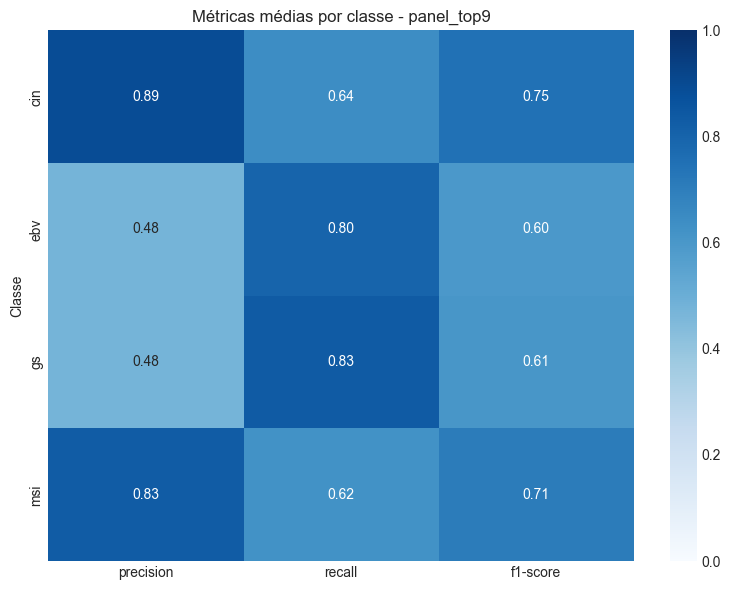

In [18]:
fig1

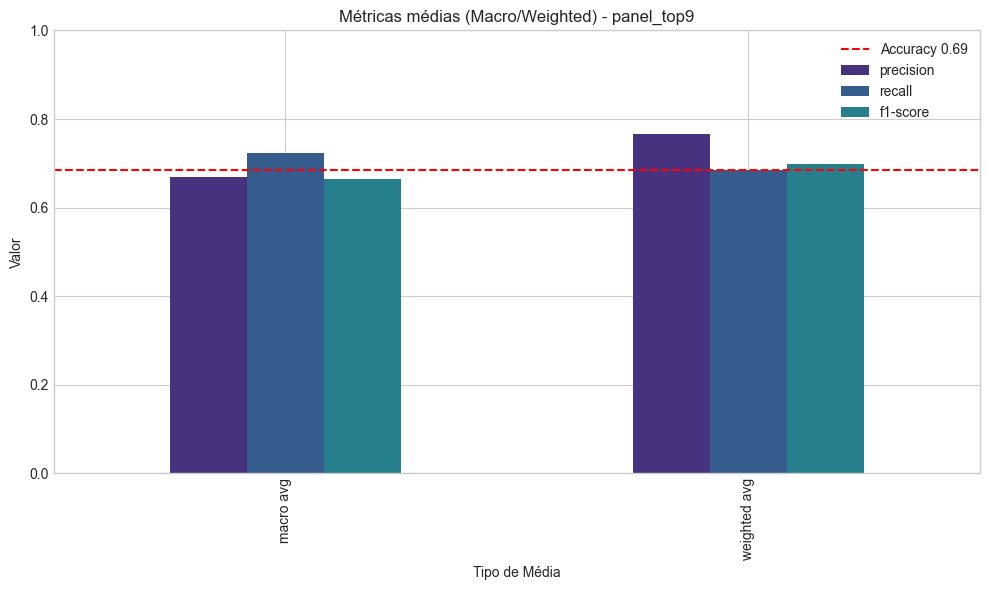

In [19]:
fig2